# Uczenie maszynowe: Lab4

### Inżynieria cech
Inżynieria cech to proces przekształcania danych w celu poprawy wydajności modeli uczenia maszynowego. Obejmuje to zarówno redukcję wymiarowości (np. metodą PCA), jak i selekcję cech, aby wybrać najbardziej informacyjne cechy.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.datasets import load_digits
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score


#### Selekcja cech (różne algorytmy).
Selekcja cech polega na wyborze podzbioru cech, które są najbardziej istotne dla danego problemu predykcyjnego. Można to zrobić na różne sposoby, np. na podstawie znaczenia cech określonego przez model lub poprzez univariate selection, gdzie każda cecha jest oceniana indywidualnie.
- Celem jest zredukowanie liczby cech do tych, które są najbardziej informatywne i istotne dla modelu, co może prowadzić do poprawy jego wydajności, uproszczenia modelu i zmniejszenia ryzyka przeuczenia (overfitting).

- SelectFromModel: Metoda selekcji cech na podstawie znaczenia cech z lasu losowego.
- SelectKBest: Metoda selekcji cech oparta na statystykach ANOVA.
- RFE (Recursive Feature Elimination): Rekursywna eliminacja cech przy użyciu regresji logistycznej.

Dokładność na zbiorze testowym (bez selekcji cech): 0.9766
Raport klasyfikacji (bez selekcji cech):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

Dokładność na zbiorze testowym (znaczenie cech): 0.9708
Raport klasyfikacji (znaczenie cech):
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Dokładność na zbiorze testowym (SelectKBest): 0.9708
Raport klasyfikacji (SelectKBest):
               precision    recall  f1-score   support

      

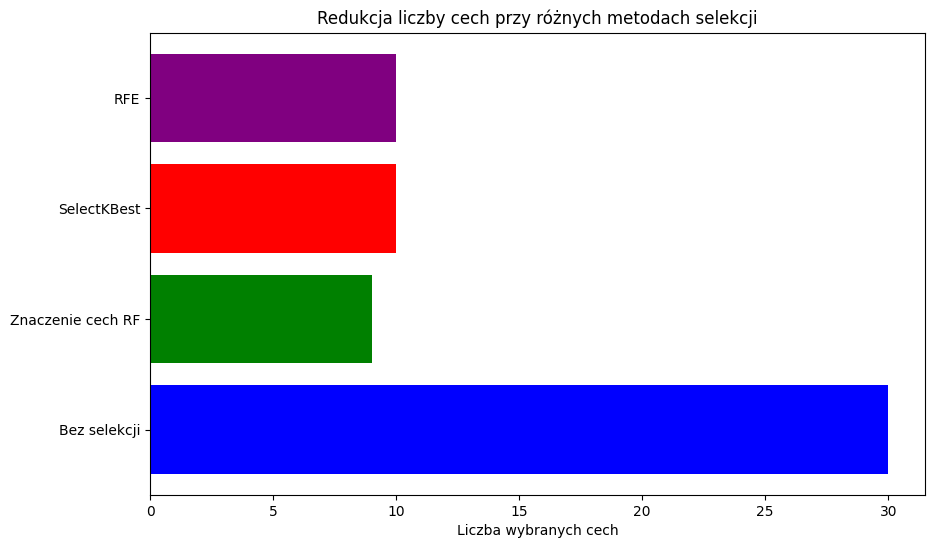

In [15]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Załadowanie danych dotyczących raka piersi
data = load_breast_cancer()
X = data.data
y = data.target

# Usunięcie stałych cech
X = X[:, X.var(axis=0) > 0]

# Podział danych na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Trenowanie modelu SVC bez selekcji cech
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez selekcji cech): {accuracy:.4f}")
print("Raport klasyfikacji (bez selekcji cech):\n", classification_report(y_test, y_pred, zero_division=1))

# Selekcja cech na podstawie znaczenia cech
selector = SelectFromModel(rf, prefit=True)
X_train_rf = selector.transform(X_train)
X_test_rf = selector.transform(X_test)

# Trenowanie modelu z selekcją cech (znaczenie cech)
model.fit(X_train_rf, y_train)
y_pred_rf = model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Dokładność na zbiorze testowym (znaczenie cech): {accuracy_rf:.4f}")
print("Raport klasyfikacji (znaczenie cech):\n", classification_report(y_test, y_pred_rf, zero_division=1))

# Selekcja cech za pomocą SelectKBest (ANOVA)
selector = SelectKBest(score_func=f_classif, k=10)
X_train_best = selector.fit_transform(X_train, y_train)
X_test_best = selector.transform(X_test)

# Trenowanie modelu po selekcji cech (SelectKBest)
model.fit(X_train_best, y_train)
y_pred_best = model.predict(X_test_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Dokładność na zbiorze testowym (SelectKBest): {accuracy_best:.4f}")
print("Raport klasyfikacji (SelectKBest):\n", classification_report(y_test, y_pred_best, zero_division=1))

# Selekcja cech za pomocą RFE
log_reg = LogisticRegression(solver='liblinear')
rfe = RFE(estimator=log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Trenowanie modelu po selekcji cech (RFE)
model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
print(f"Dokładność na zbiorze testowym (RFE): {accuracy_rfe:.4f}")
print("Raport klasyfikacji (RFE):\n", classification_report(y_test, y_pred_rfe, zero_division=1))

# Walidacja krzyżowa z RandomForestClassifier na oryginalnych danych
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest): {np.mean(cv_scores):.4f}")

# Walidacja krzyżowa z selekcją cech na podstawie znaczenia cech
X_rf = selector.transform(X)
cv_scores_rf = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_rf, y, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest z znaczeniem cech): {np.mean(cv_scores_rf):.4f}")

# Walidacja krzyżowa z SelectKBest
X_best = selector.transform(X)
cv_scores_best = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_best, y, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest z SelectKBest): {np.mean(cv_scores_best):.4f}")

# Walidacja krzyżowa z RFE
X_rfe = rfe.transform(X)
cv_scores_rfe = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_rfe, y, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest z RFE): {np.mean(cv_scores_rfe):.4f}")

# Wyświetlenie cech przed i po selekcji
original_features = data.feature_names
selected_features_rf = original_features[selector.get_support()]
selected_features_best = original_features[selector.get_support()]
selected_features_rfe = original_features[rfe.get_support()]

print("\n")

feature_df = pd.DataFrame({
    "Cechy oryginalne": original_features,
    "Wybrane przez znaczenie cech RF": [f if f in selected_features_rf else "" for f in original_features],
    "Wybrane przez SelectKBest": [f if f in selected_features_best else "" for f in original_features],
    "Wybrane przez RFE": [f if f in selected_features_rfe else "" for f in original_features]
})
print(feature_df)

# Wykres redukcji liczby cech
methods = ['Bez selekcji', 'Znaczenie cech RF', 'SelectKBest', 'RFE']
num_features = [X_train.shape[1], X_train_rf.shape[1], X_train_best.shape[1], X_train_rfe.shape[1]]

plt.figure(figsize=(10, 6))
plt.barh(methods, num_features, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Liczba wybranych cech')
plt.title('Redukcja liczby cech przy różnych metodach selekcji')
plt.show()

### Redukcja wymiarowości: Metoda PCA
Principal Component Analysis (PCA) to statystyczna metoda analizy danych, która przekształca dane o wysokiej wymiarowości na dane o mniejszej liczbie wymiarów. Celem PCA jest zredukowanie liczby wymiarów przy jednoczesnym zachowaniu jak największej ilości informacji zawartej w oryginalnych danych.
- PCA może prowadzić do mniejszej dokładności modelu w porównaniu do modelu trenowanego bez redukcji wymiarowości. Dzieje się tak dlatego, że PCA zmniejsza liczbę cech, co może skutkować utratą istotnych informacji zawartych w danych. W niektórych przypadkach, szczególnie jeśli liczba wybranych komponentów jest zbyt mała, model może nie być w stanie uchwycić wszystkich istotnych wzorców w danych.

In [10]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Wczytywanie danych
data = load_digits()
X = data.data
y = data.target

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu bez redukcji wymiarowości
model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=cv, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez redukcji): {accuracy:.4f}")
print("Raport klasyfikacji (bez redukcji):\n", classification_report(y_test, y_pred))

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=2)  # oznacza, że PCA zredukuje wymiarowość danych do dwóch głównych składowych.
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Trenowanie modelu po redukcji wymiarowości za pomocą PCA
grid_search_rf.fit(X_train_pca, y_train)
best_rf_pca = grid_search_rf.best_estimator_

best_rf_pca.fit(X_train_pca, y_train)
y_pred_pca = best_rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"\nDokładność na zbiorze testowym (PCA): {accuracy_pca:.4f}")
print("Raport klasyfikacji (PCA):\n", classification_report(y_test, y_pred_pca))

# Walidacja krzyżowa z PCA i RandomForestClassifier
cv_scores_pca = cross_val_score(best_rf_pca, X_train_pca, y_train, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest z PCA): {np.mean(cv_scores_pca):.4f}")


# Wypisanie wszystkich cech przed PCA dla pierwszej próbki
features_before_pca = X_train[0]
print("\nWszystkie cechy przed PCA (pierwsza próbka):")
for i, feature in enumerate(features_before_pca):
    print(f"Cech {i+1:2d}: {feature:.4f}")

# Wypisanie wszystkich cech po PCA dla pierwszej próbki
features_after_pca = X_train_pca[0]
print("\nWszystkie cechy po PCA (pierwsza próbka):")
for i, feature in enumerate(features_after_pca):
    print(f"Cech {i+1:2d}: {feature:.4f}")

Dokładność na zbiorze testowym (bez redukcji): 0.9694
Raport klasyfikacji (bez redukcji):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.93      0.95        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360


Dokładność na zbiorze testowym (PCA): 0.5583
Raport klasyfikacji (PCA):
               precision    recall  f1-score   support

           0       0.

### Ekstrakcja cech: transformacje
(feature extraction) odnosi się do procesu przekształcania surowych danych w zestaw cech, które mogą być użyte do trenowania modelu. Celem ekstrakcji cech jest zmniejszenie liczby cech, zachowując jednocześnie istotne informacje z danych.

In [6]:
from sklearn.preprocessing import PolynomialFeatures


# Ignorowanie ostrzeżeń o zbieżności
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Wczytywanie danych
data = load_digits()
X = data.data
y = data.target

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych (do średniej 0 i odchylenia 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu bez ekstrakcji cech
model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=cv, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez ekstrakcji cech): {accuracy:.4f}")
print("Raport klasyfikacji (bez ekstrakcji cech):\n", classification_report(y_test, y_pred))

# Walidacja krzyżowa bez ekstrakcji cech
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest bez ekstrakcji cech): {np.mean(cv_scores):.4f}")

# Ekstrakcja cech za pomocą transformacji (PolynomialFeatures)
# Tworzenie nowych cech będących kombinacjami wielomianowymi oryginalnych cech.
poly = PolynomialFeatures(degree=2, include_bias=False) # degree -> stopień wielomianu, include_bias -> czy dodać kolumnę z jedynkami
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Trenowanie modelu z ekstrakcją cech (PolynomialFeatures)
grid_search_rf.fit(X_train_poly, y_train)
best_rf_poly = grid_search_rf.best_estimator_

best_rf_poly.fit(X_train_poly, y_train)
y_pred_poly = best_rf_poly.predict(X_test_poly)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
print(f"Dokładność na zbiorze testowym (PolynomialFeatures): {accuracy_poly:.4f}")
print("Raport klasyfikacji (PolynomialFeatures):\n", classification_report(y_test, y_pred_poly))

# Walidacja krzyżowa z ekstrakcją cech (PolynomialFeatures)
cv_scores_poly = cross_val_score(best_rf_poly, X_train_poly, y_train, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest z PolynomialFeatures): {np.mean(cv_scores_poly):.4f}")


Dokładność na zbiorze testowym (bez ekstrakcji cech): 0.9694
Raport klasyfikacji (bez ekstrakcji cech):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.93      0.95        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360

Dokładność walidacji krzyżowej (RandomForest bez ekstrakcji cech): 0.9742
Dokładność na zbiorze testowym (PolynomialFeatures): 0.9722
Ra

### Ważność cech (w wytrenowanym modelu)
(feature importance) odnosi się do metryki, która mierzy, jak bardzo dana cecha (zmienna) przyczynia się do predykcji modelu. 

In [7]:
# Ignorowanie ostrzeżeń o zbieżności
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Wczytywanie danych
data = load_digits()
X = data.data
y = data.target

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu bez redukcji wymiarowości
model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=cv, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez redukcji): {accuracy:.4f}")
print("Raport klasyfikacji (bez redukcji):\n", classification_report(y_test, y_pred))

# Ważność cech
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Ważność cech:")
for i in range(10):
    print(f"{i + 1}. Cecha {indices[i]}: {importances[indices[i]]:.4f}")

# Ekstrakcja cech za pomocą transformacji (PolynomialFeatures)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Trenowanie modelu z ekstrakcją cech (PolynomialFeatures)
grid_search_rf.fit(X_train_poly, y_train)
best_rf_poly = grid_search_rf.best_estimator_

best_rf_poly.fit(X_train_poly, y_train)
y_pred_poly = best_rf_poly.predict(X_test_poly)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
print(f"Dokładność na zbiorze testowym (PolynomialFeatures): {accuracy_poly:.4f}")
print("Raport klasyfikacji (PolynomialFeatures):\n", classification_report(y_test, y_pred_poly))

# Ważność cech po ekstrakcji (PolynomialFeatures)
importances_poly = best_rf_poly.feature_importances_
indices_poly = np.argsort(importances_poly)[::-1]

print("Ważność cech po ekstrakcji (PolynomialFeatures):")
for i in range(10):
    print(f"{i + 1}. Cecha {indices_poly[i]}: {importances_poly[indices_poly[i]]:.4f}")

# Walidacja krzyżowa z ekstrakcją cech (PolynomialFeatures)
cv_scores_poly = cross_val_score(best_rf_poly, X_train_poly, y_train, cv=cv)
print(f"Dokładność walidacji krzyżowej (RandomForest z PolynomialFeatures): {np.mean(cv_scores_poly):.4f}")

Dokładność na zbiorze testowym (bez redukcji): 0.9694
Raport klasyfikacji (bez redukcji):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.93      0.95        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360

Ważność cech:
1. Cecha 21: 0.0500
2. Cecha 43: 0.0443
3. Cecha 36: 0.0404
4. Cecha 26: 0.0390
5. Cecha 42: 0.0358
6. Cecha 28: 0.0325
7. Cecha 30: 0.0